## Abstract: This notebook will be used for the capstone project


In [103]:
# Load libraries
import os
import numpy as np
from scipy.stats import mode
import io


import pandas as pd
import shutil
from PIL import Image


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder


In [149]:

class ImageProcessor:
    def __init__(self, csv_file, corrupt_dir, output_csv):
        self.df = pd.read_csv(csv_file)
        self.corrupt_dir = corrupt_dir
        self.output_csv = output_csv

    def is_corrupt(self, file_path):
        try:
            Image.open(file_path)
        except IOError:
            return True
        return False

    def process_image(self, file_path, size=(100, 100)):
        try:
            img = Image.open(file_path)
            img = img.resize(size)  # Resize image
            img = img / 255.0  # Standardize intensity to range [0, 1]
            img.save(file_path)
        except IOError:
            print(f"Error processing image {file_path}")
            return False
        return True

    def process_images(self):
        for index, row in self.df.iterrows():
            file_path = row['image_path']
            if self.is_corrupt(file_path):
                shutil.move(file_path, self.corrupt_dir)  # Move corrupt files to a separate directory
                self.df.drop(index, inplace=True)  # Remove the row from the DataFrame
            else:
                if not self.process_image(file_path):
                    self.df.drop(index, inplace=True)  # If there was an error processing the image, remove the row
        self.df.to_csv(self.output_csv, index=False)  # Save the updated DataFrame to a new CSV file


In [155]:
class DF_Comparison:
    def __init__(self, df1, df2):
        self.df1 = df1
        self.df2 = df2
        
    def report(self):
        print("\nDataFrame 1 info:")
        print("\n:")
        self.print_info(self.df1)

        print("\nDataFrame 2 info:")
        self.print_info(self.df2)
        
        print("\nMissing values:")
        print(self.df1.isnull().sum())
        print(self.df2.isnull().sum())

        print("\nUnique values:")
        for column in self.df1.columns:
            print(f"{column}: {self.df1[column].nunique()}")
            print("---")
            print(f"{column}: {self.df2[column].nunique()}")
        print("\nValue counts:")

        for column in self.df1.columns:
            print(f"{column}: {self.df1[column].value_counts()}")
            print("---")
            print(f"{column}: {self.df1[column].value_counts()}")

        print("\nDescriptive statistics:")
        print(self.df1.describe())
        print(self.df2.describe())

        print("\nTop Five Rows:")
        print(self.df1.head(5))
        print(self.df2.head(5))

        
    def print_info(self,df):
        # Capture df.info() output in a string
        buf = io.StringIO()
        df.info(buf=buf)
        info_str = buf.getvalue()

        # Create a summary DataFrame
        info_list = info_str.split('\n')[5:-3]  # Remove first and last two lines
        info_data = [line.split() for line in info_list]  # Split each line into list of words
        # Create dataframe from info_data
        info_df = pd.DataFrame(info_data, columns=['index', 'Name', 'Count', 'Non-Null','Dtype'])

        # Print the summary DataFrame in markdown format
        print(info_df.to_markdown(index=False))
        print("\n")



In [151]:


class DataCleaner:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()

       
    def report_and_recommend(self):
        
        print("\nRecommendations:")

        for column in self.df.columns:
            if self.df[column].isnull().sum() > 0:
                print(f"- Column '{column}' has missing values. Consider using dropna() or fillna().")

            if self.df[column].dtype == 'object':
                print(f"- Column '{column}' is categorical. Consider encoding it using label encoding or one-hot encoding.")
            
            elif self.df[column].dtype in ['int64', 'float64']:
                print(f"- Column '{column}' is numerical. Consider scaling it using standard scaling or min-max scaling.")

        print("\nRecommendations - END -:")
   
    def visualize(self, column):
        if self.df[column].dtype in ['int64', 'float64']:
            self.df[column].hist()
            plt.xlabel(column)
            plt.title(f"Histogram of {column}")
            plt.show()
        else:
            sns.countplot(x=column, data=self.df)
            plt.title(f"Count plot of {column}")
            plt.show()
   
    def drop_missing(self):
        self.df.dropna(inplace=True)

    def fill_missing(self, column, value):
        self.df[column].fillna(value, inplace=True)

    def encode_categorical(self, column):
        self.df[column] = self.encoder.fit_transform(self.df[column])

    def scale_numerical(self, column):
        self.df[column] = self.scaler.fit_transform(self.df[column].values.reshape(-1, 1))

    def fill_missing_numeric_With_mean(self, column1, column2):
        # Calculate the mean of 'column1' for each category in 'column2'
        mean_values = self.df.groupby(column2)[column1].mean()

        # Fill the missing values in 'column1' with the mean of 'column1' in the same category in 'column2'
        self.df[column1] = self.df.apply(
             lambda row: mean_values[row[column2]] if pd.isnull(row[column1]) else row[column1],axis=1)
        
    def fill_missing_Category_values(self, column1, column2):
       
        # # Define a lambda function to compute the mode
        fill_mode = lambda x: x.fillna(x.mode().iloc[0])

        # # Fill missing values in column1 column with the mode of the corresponding group in column2
        self.df[column1] = self.df.groupby(column2)[column1].transform(fill_mode)
        
        
       


In [106]:

# # Usage
# processor = ImageProcessor('images.csv', 'corrupt_files', 'new_images.csv')
# processor.process_images()

# # Load your dataframe
# df = pd.read_csv('metadata.csv')  # replace with your actual path

# cleaner = DataCleaner(df)

# # Pre-cleaning report
# cleaner.report()

# # Handle missing values
# cleaner.drop_missing()  # or cleaner.fill_missing('column_name', value)

# # Encode categorical variables
# cleaner.encode_categorical('categorical_column')  # replace 'categorical_column' with your actual column

# # Scale numerical variables
# cleaner.scale_numerical('numerical_column')  # replace 'numerical_column' with your actual column

# # Post-cleaning report
# cleaner.report()


DataFrame 1 info:

:
|   index | Name                          |   Count | Non-Null   | Dtype   |
|--------:|:------------------------------|--------:|:-----------|:--------|
|       0 | image_name                    |   33126 | non-null   | object  |
|       1 | patient_id                    |   33126 | non-null   | object  |
|       2 | sex                           |   33061 | non-null   | object  |
|       3 | age_approx                    |   33058 | non-null   | float64 |
|       4 | anatom_site_general_challenge |   32599 | non-null   | object  |
|       5 | diagnosis                     |   33126 | non-null   | object  |
|       6 | benign_malignant              |   33126 | non-null   | object  |
|       7 | target                        |   33126 | non-null   | int64   |



DataFrame 2 info:
|   index | Name                          |   Count | Non-Null   | Dtype   |
|--------:|:------------------------------|--------:|:-----------|:--------|
|       0 | image_name           

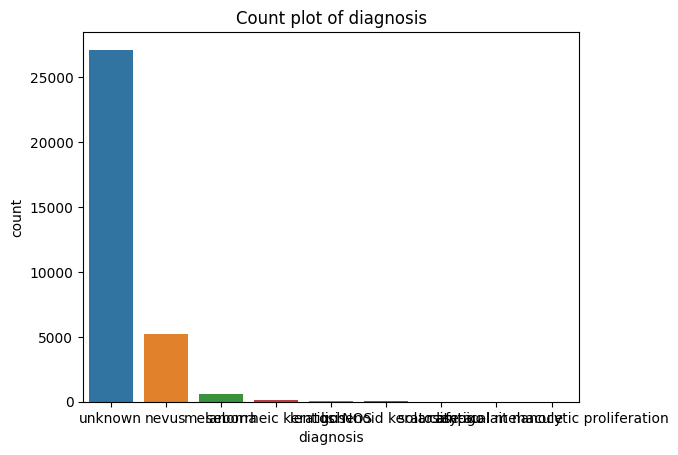

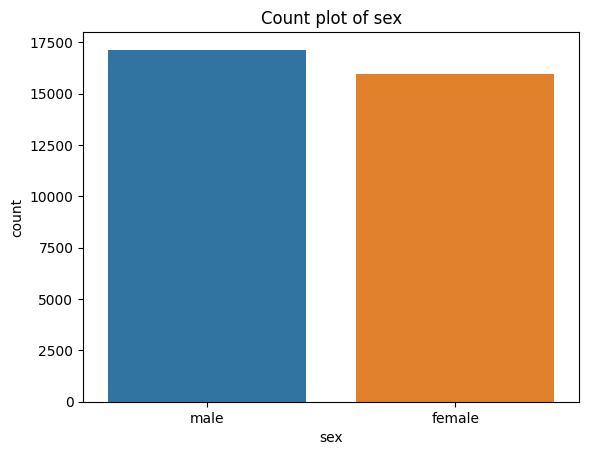

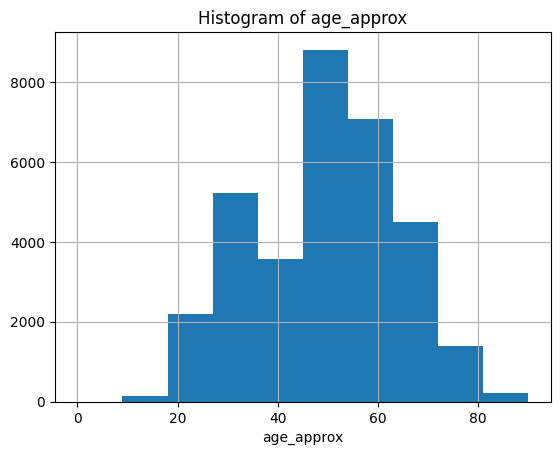

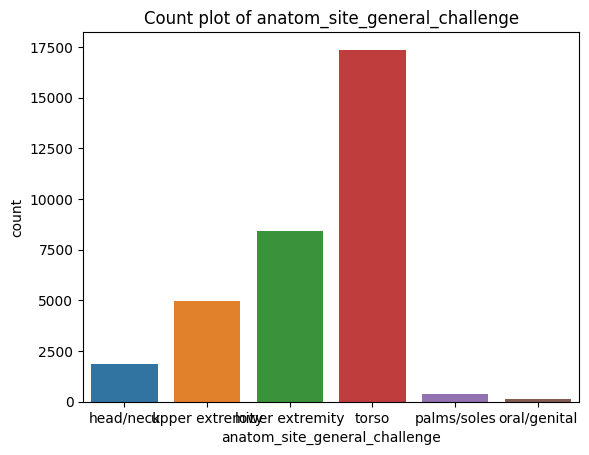

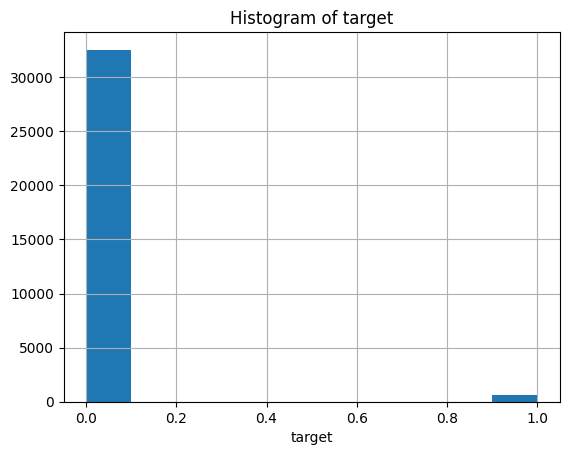

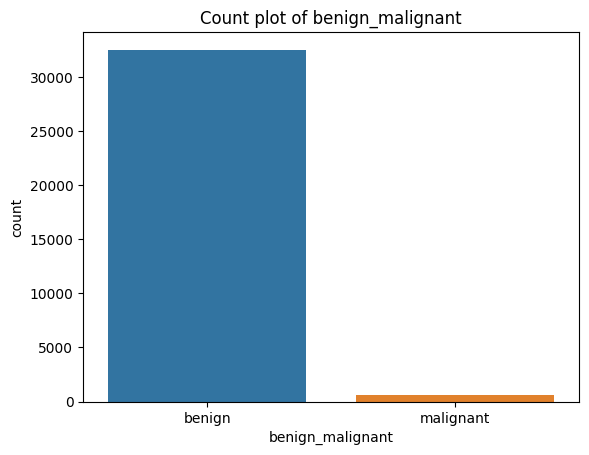

In [156]:
# Define row CSV file name and path
File_name = 'train.csv'
Path_Name = 'Data/Row_data(pre)'
row_csv_file = os.path.join(Path_Name, File_name)
df_org  = pd.read_csv(row_csv_file)
df_new = df_org.copy()
DF_Comparison_1 = DF_Comparison(df_org, df_new)
DF_Comparison_1.report()

cleaner_1 = DataCleaner(df_org)
cleaner_2 = DataCleaner(df_new)
cleaner_1.report_and_recommend()
cleaner_2.fill_missing_numeric_With_mean('age_approx', 'diagnosis')
cleaner_2.fill_missing_Category_values('anatom_site_general_challenge', 'diagnosis')
cleaner_2.fill_missing_Category_values('sex', 'diagnosis')
cleaner_2.report_and_recommend()
DF_Comparison_1.report()



#cleaner.report()
cleaner_2.visualize('diagnosis')
cleaner_2.visualize('sex')
cleaner_2.visualize('age_approx')
cleaner_2.visualize('anatom_site_general_challenge')
cleaner_2.visualize('target')
cleaner_2.visualize('benign_malignant')

In [22]:


# Read 2020 Competition CSV
sample_submission_df_2020 = pd.read_csv("Data/Row_data(pre)/sample_submission.csv")
test_df_2020  = pd.read_csv("Data/Row_data(pre)/test.csv")
train_df_2020  = pd.read_csv("Data/Row_data(pre)/train.csv")

In [23]:
# Get DF Shape
print("For 2020 RAW Data")
print(sample_submission_df_2020.shape)
print(test_df_2020.shape)
print(train_df_2020.shape)
print('\n')

sample_submission_df_2020.info()
test_df_2020.info()
train_df_2020.info()



For 2020 RAW Data
(10982, 2)
(10982, 5)
(33126, 8)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  10982 non-null  object
 1   target      10982 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 171.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIn

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

class DataCleaner:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()

    def report_and_recommend(self):
        print(self.df.info())
        print("\nMissing values:")
        print(self.df.isnull().sum())
        print("\nRecommendations:")

        for column in self.df.columns:
            if self.df[column].isnull().sum() > 0:
                print(f"- Column '{column}' has missing values. Consider using dropna() or fillna().")

            if self.df[column].dtype == 'object':
                print(f"- Column '{column}' is categorical. Consider encoding it using label encoding or one-hot encoding.")
            
            elif self.df[column].dtype in ['int64', 'float64']:
                print(f"- Column '{column}' is numerical. Consider scaling it using standard scaling or min-max scaling.")

    def scale_numerical(self, column):
        self.df[column] = self.scaler.fit_transform(self.df[column].values.reshape(-1, 1))

    def encode_categorical(self, column):
        self.df[column] = self.encoder.fit_transform(self.df[column])





# Generate report and recommendatio

In [25]:
# Load your dataframe
df = train_df_2020


cleaner = DataCleaner(df)

# Generate report and recommendations
cleaner.report_and_recommend()

# Scale numerical columns and encode categorical columns
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        cleaner.scale_numerical(column)
    elif df[column].dtype == 'object':
        cleaner.encode_categorical(column)

df2 = cleaner.df
df2.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB
None

Missing values:
image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis              

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,8449,1453,1,-0.269122,0,8,0,-0.133963
1,0,610,0,-0.269122,5,8,0,-0.133963
2,1,555,0,0.078579,1,5,0,-0.133963
3,2,1374,0,-0.269122,0,8,0,-0.133963
4,3,1774,0,0.426281,5,8,0,-0.133963


In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

class DataCleaner:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()

    def report_and_recommend(self):
        print(self.df.info())
        print("\nMissing values:")
        print(self.df.isnull().sum())
        print("\nRecommendations:")

        for column in self.df.columns:
            if self.df[column].isnull().sum() > 0:
                print(f"- Column '{column}' has missing values. Consider using dropna() or fillna().")

            if self.df[column].dtype == 'object':
                print(f"- Column '{column}' is categorical. Consider encoding it using label encoding or one-hot encoding.")
            
            elif self.df[column].dtype in ['int64', 'float64']:
                print(f"- Column '{column}' is numerical. Consider scaling it using standard scaling or min-max scaling.")

    def scale_numerical(self, column):
        self.df[column] = self.scaler.fit_transform(self.df[column].values.reshape(-1, 1))

    def encode_categorical(self, column):
        self.df[column] = self.encoder.fit_transform(self.df[column])



In [27]:
# Load your dataframe
df = train_df_2020


cleaner = DataCleaner(df)

# Generate report and recommendations
cleaner.report_and_recommend()

# Scale numerical columns and encode categorical columns
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        cleaner.scale_numerical(column)
    elif df[column].dtype == 'object':
        cleaner.encode_categorical(column)
        
         
        
cleaner.report_and_recommend()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  int32  
 1   patient_id                     33126 non-null  int32  
 2   sex                            33126 non-null  int32  
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  33126 non-null  int32  
 5   diagnosis                      33126 non-null  int32  
 6   benign_malignant               33126 non-null  int32  
 7   target                         33126 non-null  float64
dtypes: float64(2), int32(6)
memory usage: 1.3 MB
None

Missing values:
image_name                        0
patient_id                        0
sex                               0
age_approx                       68
anatom_site_general_challenge     0
diagnosis                         0
beni

In [28]:
print('2020 Raw DataSet')
print("Total images in Train set 2020: ",train_df_2020['image_name'].count())
print("Total images in Test set 2020: ",test_df_2020['image_name'].count())

2020 Raw DataSet
Total images in Train set 2020:  33126
Total images in Test set 2020:  10982


In [29]:
print('Test Data Set Sample')
train_df_2020.head()

Test Data Set Sample


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,8449,1453,1,-0.269122,0,8,0,-0.133963
1,0,610,0,-0.269122,5,8,0,-0.133963
2,1,555,0,0.078579,1,5,0,-0.133963
3,2,1374,0,-0.269122,0,8,0,-0.133963
4,3,1774,0,0.426281,5,8,0,-0.133963


In [30]:
print('Train set 2020 RAW missing values')
display(pd.DataFrame(train_df_2020.isnull().sum(), columns=['Null count']))
print('Test set 2020 RAW missing values')
display(pd.DataFrame(test_df_2020.isnull().sum(), columns=['Null count']))

Train set 2020 RAW missing values


,Null count
image_name,0
patient_id,0
sex,0
age_approx,68
anatom_site_general_challenge,0
diagnosis,0
benign_malignant,0
target,0


Test set 2020 RAW missing values


,Null count
image_name,0
patient_id,0
sex,0
age_approx,0
anatom_site_general_challenge,351
